In [13]:
import sys
import os
# Add the 'scripts/' directory to the system path
sys.path.append(os.path.abspath('../triple_mbhb'))

In [14]:
import Trip_utils as util
import numpy as np
import Triple_dynamics as Tr
import spin_models as spin

import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import Kickrateplots as kickplots
import merger_rate_calculate as mr
from scipy.stats import binned_statistic
import scipy as sp

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [50]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [72]:
plt.rc('font', family='serif')

In [75]:
plt.rc('text', usetex=True)

In [78]:
plt.style.use(['science','no-latex'])

In [37]:

# import scienceplots
# plt.style.use(['science']) 
#os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

### Load the objects

In [38]:
import pickle
Nruns = 200
#Nruns = 2
iso_filename = os.path.abspath('../obj_data/iso_bin_wkick.pkl')
weak_tr_filename = os.path.abspath('../obj_data/weak_tr_wkick.pkl')
strong_tr_filename =os.path.abspath(f'../obj_data/tr{Nruns}_wkick.pkl')
stalled_tr_filename=os.path.abspath(f'../obj_data/stalled{Nruns}.pkl')

with open(iso_filename, 'rb') as f:
    iso_bin = pickle.load(f)

with open(weak_tr_filename, 'rb') as f:
    weak_tr = pickle.load(f)

with open(strong_tr_filename, 'rb') as f:
    strong_tr = pickle.load(f)

with open(stalled_tr_filename, 'rb') as f:
    stalled_objs = pickle.load(f)


In [39]:
print(f"Number of iso binaries is {iso_bin.N_iso_binaries} and it is {iso_bin.N_iso_binaries/9234*100:.2f} %")
print(f"Number of weak triples is {weak_tr.N_weak_triples} and it is {weak_tr.N_weak_triples/9234*100:.2f} %")

Number of iso binaries is 7205 and it is 78.03 %
Number of weak triples is 1509 and it is 16.34 %


#### Strong triple stats

In [40]:
strong_tr_tot_merger = util.Trip_stats(strong_tr)

Average prompt merger is 111.86 which is 21.51 %
Average merger after ejection is 248.605 which is 47.81 %
There are 159.54 no mergers on average which is 30.68%
Average total mergers is 360.465 which is 69.32 %
----------------------
Without triple interactions 210(40.4)% strong triple inner binary merges with just inspiral
With triple interactions added 360.5(69.3)% strong triple system has mergers which is a 28.9 % increase in mergers
208.5 (40.1%) strong triple induced mergers are otherwise non mergers under binary inspiral evolution.


In [41]:
exchanges_Tr_ej = []
exchanges = []
for i in range(Nruns):
    scatter_event_mask = (strong_tr[i].a_triple_after<=strong_tr[i].a_triple_ovtks_ill)
    exchanges.append(np.sum(~scatter_event_mask))
    exchanges_Tr_ej.append(np.sum((~scatter_event_mask)&strong_tr[i].merger_after_ejection_mask))

In [42]:
np.mean(exchanges_Tr_ej)
print(f"{np.mean(exchanges_Tr_ej)/189 * 100:.2f} % are exchange events in mergers after kick")

28.80 % are exchange events in mergers after kick


#### Merger population

In [43]:
import merger_population_stats as mrstat

In [44]:
mrstat.median_values_q_M_z(strong_tr,weak_tr,iso_bin,Nruns)

q merger mean for iso:0.253
qin merger for weak:0.400
qin merger for strong:0.626
----------------------------------------
M mean for iso:7.59
M mean for weak:7.988
M mean for strong:7.897
------------------------------------------
z min for strong:0.002
z max for strong:4.275
z min for iso binary 0.000
z max for iso binary 6.460
------------------------------------------


In [45]:
lgq_bins,lgM_bins,lgz_bins,Nq,Nm,Nz = mrstat.M_q_z_dist_for_mergers(strong_tr,weak_tr,iso_bin,Nruns)

In [79]:
color_palette = {"strong_trip":"#377eb8","weak_trip":"#a2c8ec","iso":"#ff800e","all":"#898989","stalled":'red'}
fig,ax = plt.subplots(1,3,figsize=[10,4],sharey=True)
ax[0].step(lgq_bins,Nq[0],label="isolated binaries",color=color_palette["iso"])
ax[0].step(lgq_bins,Nq[1],label="weak triples",color=color_palette["weak_trip"])
ax[0].step(lgq_bins,Nq[2],label="strong triples",color=color_palette["strong_trip"])
ax[0].set_xticks([-4,-3,-2,-1,0])
ax[0].set_xlim(-4.2,0)
ax[0].set_ylim(0,)
ax[0].set_xlabel(r"$\log(q_{\text{mrg}})$")
ax[0].set_ylabel("density")

ax[1].step(lgM_bins,Nm[0],label="isolated binaries",color=color_palette["iso"])
ax[1].step(lgM_bins,Nm[1],label="weak triples",color=color_palette["weak_trip"])
ax[1].step(lgM_bins,Nm[2],label="strong triples",color=color_palette["strong_trip"])
ax[1].set_xlabel(r"$\log(M_{\text{mrg}})$")
ax[1].set_xticks([6,7,8,9,10])

ax[2].step(lgz_bins,Nz[0],label="isolated binaries",color=color_palette["iso"])
ax[2].step(lgz_bins,Nz[1],label="weak triples",color=color_palette["weak_trip"])
ax[2].step(lgz_bins,Nz[2],label="strong triples",color=color_palette["strong_trip"])
ax[2].set_xlabel(r"$\log(z)$")
ax[2].set_xticks([-3,-2,-1,0,1])
ax[0].legend(fontsize=12)
fig.tight_layout()

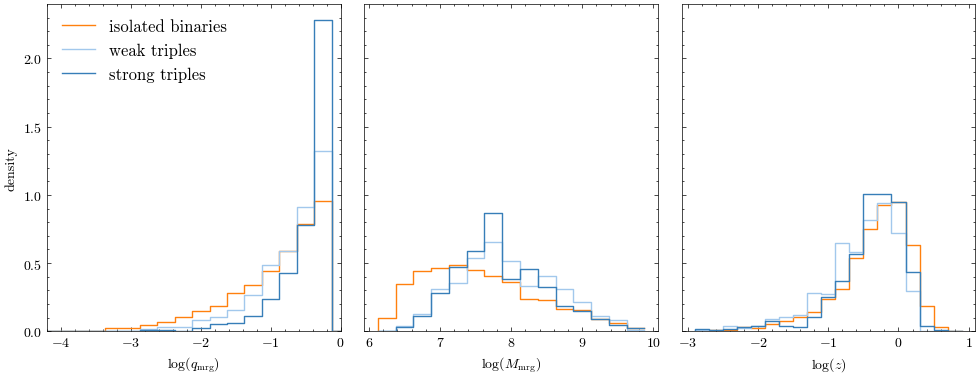

In [80]:
fig

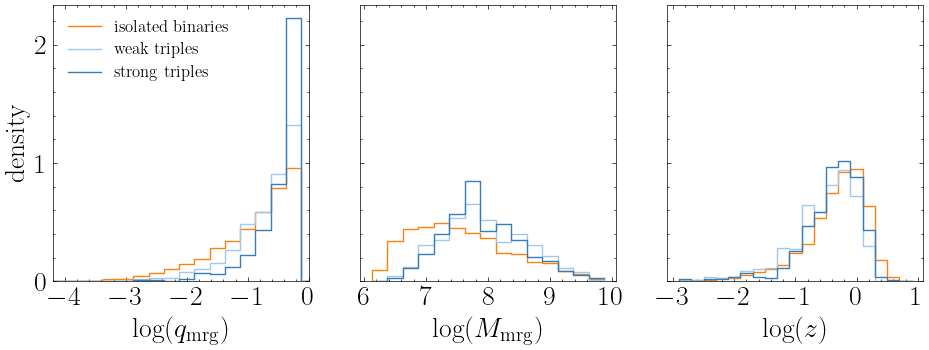

In [13]:
color_palette = {"strong_trip":"#377eb8","weak_trip":"#a2c8ec","iso":"#ff800e","all":"#898989","stalled":'red'}
fig,ax = plt.subplots(1,3,figsize=[10,4],sharey=True)
ax[0].step(lgq_bins,Nq[0],label="isolated binaries",color=color_palette["iso"])
ax[0].step(lgq_bins,Nq[1],label="weak triples",color=color_palette["weak_trip"])
ax[0].step(lgq_bins,Nq[2],label="strong triples",color=color_palette["strong_trip"])
ax[0].set_xticks([-4,-3,-2,-1,0])
ax[0].set_xlim(-4.2,0)
ax[0].set_ylim(0,)
ax[0].set_xlabel(r"$\log(q_{\text{mrg}})$")
ax[0].set_ylabel("density")

ax[1].step(lgM_bins,Nm[0],label="isolated binaries",color=color_palette["iso"])
ax[1].step(lgM_bins,Nm[1],label="weak triples",color=color_palette["weak_trip"])
ax[1].step(lgM_bins,Nm[2],label="strong triples",color=color_palette["strong_trip"])
ax[1].set_xlabel(r"$\log(M_{\text{mrg}})$")
ax[1].set_xticks([6,7,8,9,10])

ax[2].step(lgz_bins,Nz[0],label="isolated binaries",color=color_palette["iso"])
ax[2].step(lgz_bins,Nz[1],label="weak triples",color=color_palette["weak_trip"])
ax[2].step(lgz_bins,Nz[2],label="strong triples",color=color_palette["strong_trip"])
ax[2].set_xlabel(r"$\log(z)$")
ax[2].set_xticks([-3,-2,-1,0,1])
ax[0].legend(fontsize=12)
fig.tight_layout()
plt.savefig("../Figures/mrg_properties_hist.pdf")

In [61]:
st_major_merger = []
for i in range(Nruns):
    st_major_merger.append(np.sum(strong_tr[i].qin_merger[strong_tr[i].merger_mask]>0.1)/520 * 100)
print(f"The strong triple mergers consist of {np.mean(st_major_merger):.1f}% major mergers")

The strong triple mergers consist of 64.6% major mergers


In [62]:
hist_Tr_ej_tot = 0
hist_Tr_tot = 0
hist_no_tot = 0

for i in range(Nruns):
    Tr_ej_qin = strong_tr[i].qin[strong_tr[i].merger_after_ejection_mask]
    Tr_ej_qout = strong_tr[i].qout[strong_tr[i].merger_after_ejection_mask]

    Tr_qin = strong_tr[i].qin[strong_tr[i].prompt_merger_mask]
    Tr_qout = strong_tr[i].qout[strong_tr[i].prompt_merger_mask]

    no_qin = strong_tr[i].qin[strong_tr[i].no_merger_mask]
    no_qout = strong_tr[i].qout[strong_tr[i].no_merger_mask]

        
    xedges =  np.linspace(-3,2,21) #logspace(aa, 21)
    yedges =  np.linspace(-2,0,21)#logspace(bb, 21)

    aa_Tr, bb_Tr = np.log10(Tr_qout),np.log10(Tr_qin)
    hist_Tr, *_ = sp.stats.binned_statistic_2d(aa_Tr, bb_Tr, None, bins=(xedges, yedges), statistic='count')
    hist_Tr_tot = hist_Tr_tot + hist_Tr

    aa_Tr_ej, bb_Tr_ej = np.log10(Tr_ej_qout),np.log10(Tr_ej_qin)
    hist_Tr_ej, *_ = sp.stats.binned_statistic_2d(aa_Tr_ej, bb_Tr_ej, None, bins=(xedges, yedges), statistic='count')
    hist_Tr_ej_tot = hist_Tr_ej_tot + hist_Tr_ej


    aa_no, bb_no = np.log10(no_qout),np.log10(no_qin)
    hist_no, *_ = sp.stats.binned_statistic_2d(aa_no, bb_no, None, bins=(xedges, yedges), statistic='count')
    hist_no_tot = hist_no_tot + hist_no
    
hist_Tr_ej_tot = hist_Tr_ej_tot/Nruns
hist_Tr_tot = hist_Tr_tot/Nruns
hist_no_tot = hist_no_tot/Nruns

In [65]:
fig,axes = plt.subplots(1,2,figsize=[16,7])
xx, yy = np.meshgrid(xedges, yedges)
#norm = mpl.colors.Normalize(0,round(hist_Tr_tot.max()))

max_val = max(hist_Tr_tot.max(), hist_Tr_ej_tot.max())
norm = mpl.colors.Normalize(0, round(max_val))

pcm1 = axes[0].pcolormesh(xedges, yedges, hist_Tr_tot.T, cmap="Blues", norm=norm)
pcm2 = axes[1].pcolormesh(xedges, yedges, hist_Tr_ej_tot.T, cmap="Blues", norm=norm)
#plt.colorbar(pcm, ax=axes[0], label='number')

for i in range(Nruns):
    qout_stalled_but_Tr = strong_tr[i].qout[(~strong_tr[i].bin_merge_flag)&(strong_tr[0].prompt_merger_mask)]
    qin_stalled_but_Tr = strong_tr[i].qin[(~strong_tr[i].bin_merge_flag)&(strong_tr[0].prompt_merger_mask)]

    qout_stalled_but_Tr_ej = strong_tr[i].qout[(~strong_tr[i].bin_merge_flag)&(strong_tr[0].merger_after_ejection_mask)]
    qin_stalled_but_Tr_ej = strong_tr[i].qin[(~strong_tr[i].bin_merge_flag)&(strong_tr[0].merger_after_ejection_mask)]

    axes[0].scatter(np.log10(qout_stalled_but_Tr),np.log10(qin_stalled_but_Tr),s=3.5,color="red",label="Binaries stalled in isolation" if i == 0 else "")
    axes[1].scatter(np.log10(qout_stalled_but_Tr_ej),np.log10(qin_stalled_but_Tr_ej),s=3.5,color="red",label="Binaries stalled in inspiral" if i == 0 else "")


#norm = mpl.colors.Normalize(0,round(hist_Tr_ej_tot.max()))

#plt.colorbar(pcm, ax=axes[1], label='number')
#axes[1].scatter(np.log10(qout_stalled_but_Tr_ej),np.log10(qin_stalled_but_Tr_ej),s=1.5,color="red")

#norm = mpl.colors.Normalize(0,round(hist_no_tot.max()))
#pcm3 = axes[2].pcolormesh(xedges, yedges, hist_no_tot.T, cmap="Blues", norm=norm)
#plt.colorbar(pcm, ax=axes[2], label='number')
#axes[2].scatter(np.log10(qout_stalled_but_no),np.log10(qin_stalled_but_no),s=0.5,color="red")

divider = make_axes_locatable(axes[1])  # Adjust based on the third axis
cax = divider.append_axes("right", size="5%", pad=0.5)
plt.colorbar(pcm1, cax=cax, label="number")

axes[0].set_xlabel("$\log_{10}(q_{out})$")
axes[1].set_xlabel("$\log_{10}(q_{out})$")


axes[0].set_ylabel("$\log_{10}(q_{in})$")
axes[1].set_ylabel("$\log_{10}(q_{in})$")


axes[0].set_title("Prompt Mergers")
axes[1].set_title("Mergers after kick")

# Add legends to both plots, outside axes with a border
legend_props = dict(edgecolor="black", linewidth=1.5)  # Custom border

#axes[0].legend(prop=legend_props, fancybox=True)
axes[0].legend(fancybox=True, framealpha=1, frameon=True, edgecolor="black",fontsize=14)

axes[0].set_ylim(-1,0)
axes[0].set_xlim(-2.5,1.5)
axes[1].set_ylim(-1,0)
axes[1].set_xlim(-2.5,1.5)

plt.tight_layout()
plt.savefig("../Figures/2d-hist-qin-qout-for-mergers.pdf")

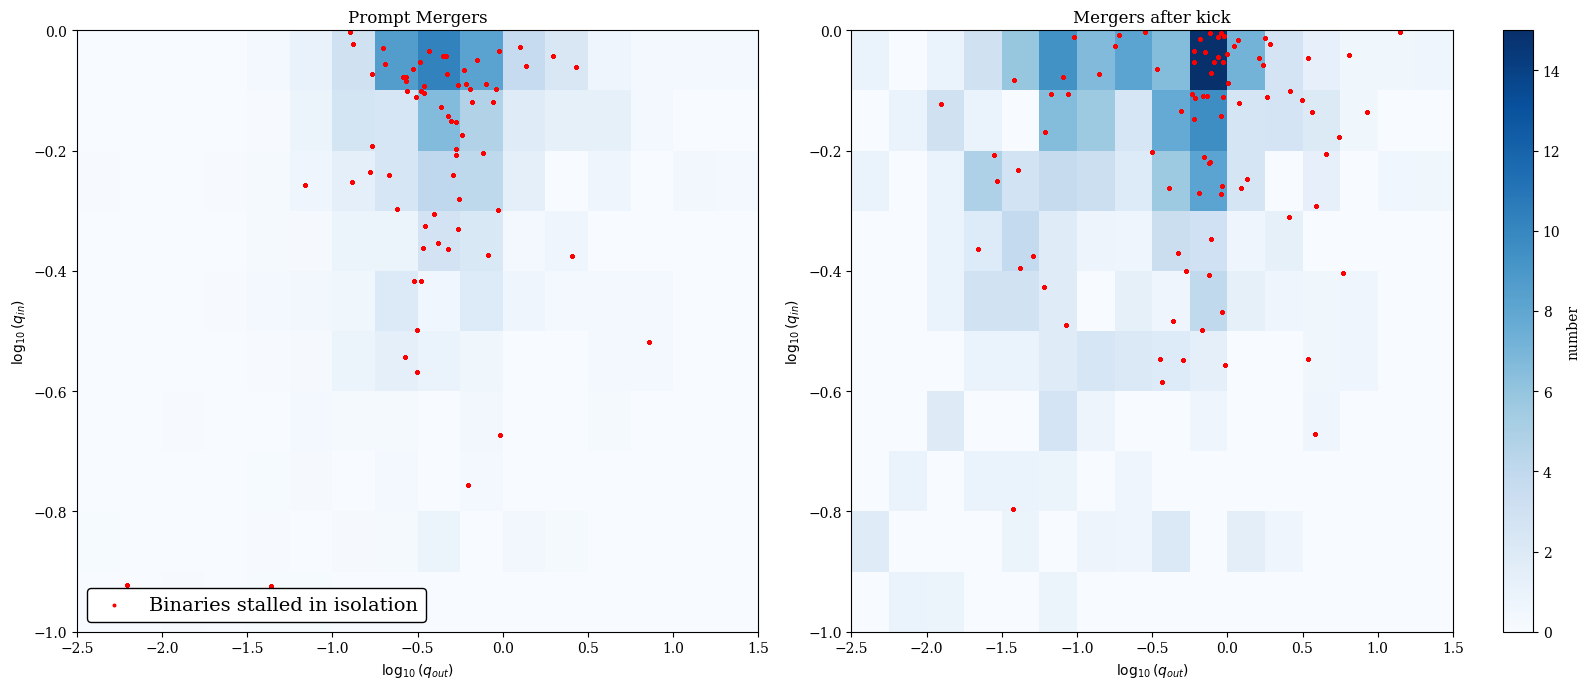

In [66]:
fig

The red dots in the right are from scattering events. Hence m3<<m1+m2. 
For higher intruder mass m3, it will most likely cause an exchange.

#### Observations

1. Prompt mergers peak around similar masses. Qout > 1 mergers refer to the big perturber case.
2. Qin decreases, Qout decreases. m2 - m3 exchange cases ?

### Scattering and exchange events

In [67]:
scatter_event_mask = (strong_tr[0].a_triple_after<=strong_tr[0].a_triple_ovtks_ill)
print(f"Number of scatter events:{np.sum(scatter_event_mask)}")
print(f"Number of mergers in scatter events:{np.sum((scatter_event_mask)&(strong_tr[0].merger_mask))}")
print(f"Number of exchange events:{np.sum(~scatter_event_mask)}")
print(f"Number of mergers in exchange events:{np.sum((~scatter_event_mask)&(strong_tr[0].merger_mask))}")

Number of scatter events:454
Number of mergers in scatter events:305
Number of exchange events:66
Number of mergers in exchange events:61


In [68]:
plt.figure(figsize=[10,7])
plt.hist(np.log10(strong_tr[0].t_bin_merger[scatter_event_mask]-strong_tr[0].t_triple_form[scatter_event_mask]),histtype="step",label="scatter event bin time")
plt.hist(np.log10(strong_tr[0].triple_mergers_times[scatter_event_mask]-strong_tr[0].t_triple_form[scatter_event_mask]),histtype="step",label="scatter event triple time")
plt.hist(np.log10(strong_tr[0].t_bin_merger[~scatter_event_mask]-strong_tr[0].t_triple_form[~scatter_event_mask]),histtype="step",label="exchange event bin time")
plt.hist(np.log10(strong_tr[0].triple_mergers_times[~scatter_event_mask]-strong_tr[0].t_triple_form[~scatter_event_mask]),histtype="step",label="exchange event triple time")
plt.legend()

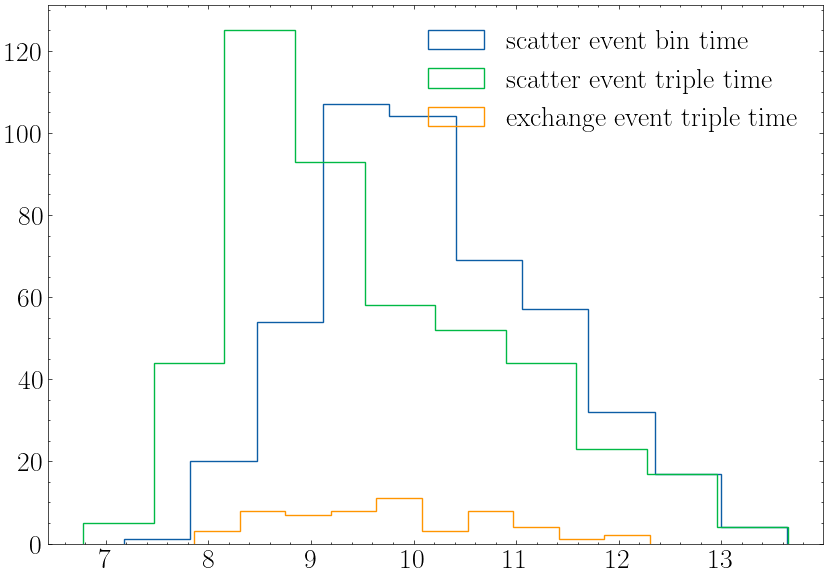

In [27]:
plt.figure(figsize=[10,7])
plt.hist(np.log10(strong_tr[0].t_bin_merger[scatter_event_mask]-strong_tr[0].t_triple_form[scatter_event_mask]),histtype="step",label="scatter event bin time")
plt.hist(np.log10(strong_tr[0].triple_mergers_times[scatter_event_mask]-strong_tr[0].t_triple_form[scatter_event_mask]),histtype="step",label="scatter event triple time")
plt.hist(np.log10(strong_tr[0].triple_mergers_times[~scatter_event_mask]-strong_tr[0].t_triple_form[~scatter_event_mask]),histtype="step",label="exchange event triple time")
plt.legend()